In [0]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap = matplotlib.cm.get_cmap('Spectral')

import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier,AdaBoostRegressor

# Ejemplo de Boosting y Feature Selection

Vamos a tratar de ver alguna aplicacion de lo visto la clase pasada. Para eso, implementaremos un algoritmo de Boosting. En particular, voy a aprovechar para bucear un poco en otras cosas.

# El problema:

En esta cuarentena, yo estoy con abstinencia de deportes. En particular, me cortaron la temporada de NBA. Con mi grupo de adictos, empezamos a charlar para matar el tiempo y me surgio una pregunta. ~Puedo hablar de basquet en vez de trabajar?~ Puedo mentir con seguridad sobre las estadisticas que leo en los articulos?

Para eso, me puse a explorar un poco. En primer lugar, necesito datos. Para eso, recurro a una pagina llamada basketballreference.com donde se almacenan todos los datos posibles. Para hacer las cosas mas simples, me voy a limitar a una unica temporada, en la que los roles posicionales son mas o menos los mismos en la liga (salvo en Houston) y no tengo jugadores repetidos (salvo los que fueron transferidos, pero ahora mismo no me interesa ser demasiado cauto en el procesado).

In [0]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

In [0]:
BeautifulSoup?

In [0]:
url = "https://www.basketball-reference.com/leagues/NBA_{}_advanced.html".format(2016)# this is the HTML from the given URL
html = urlopen(url)
soup = BeautifulSoup(html)

In [0]:
soup.findAll('tr', limit=2)# use getText()to extract the text we need into a list
headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]# exclude the first column as we will not need the ranking order from Basketball Reference for the analysis

In [0]:
headers = headers[1:]
rows = soup.findAll('tr')[1:]
player_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
stats = pd.DataFrame(player_stats, columns = headers)
stats=stats.drop('\xa0',axis=1)

In [0]:
stats.head()

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,Quincy Acy,PF,25,SAC,59,876,14.7,.629,.229,.318,8.1,15.1,11.6,4.4,1.6,2.2,10.0,13.1,1.8,0.7,2.5,.137,-0.2,0.2,-0.1,0.4
1,Jordan Adams,SG,21,MEM,2,15,17.3,.427,.167,.833,0.0,15.9,7.6,31.9,10.3,0.0,19.6,30.5,0.0,0.0,0.0,.015,-2.5,9.4,6.9,0.0
2,Steven Adams,C,22,OKC,80,2014,15.5,.621,.000,.460,12.5,16.1,14.4,4.3,1.0,3.3,14.1,12.6,4.2,2.3,6.5,.155,0.0,0.2,0.2,1.1
3,Arron Afflalo,SG,30,NYK,71,2371,10.9,.531,.298,.164,1.1,11.0,6.1,9.9,0.5,0.3,8.7,17.9,1.8,0.9,2.7,.055,-1.3,-1.6,-2.9,-0.5
4,Alexis Ajinça,C,27,NOP,59,861,13.8,.514,.003,.197,9.3,25.9,17.3,5.8,1.1,3.4,13.6,20.4,0.2,0.9,1.0,.058,-3.4,-0.6,-4.0,-0.4


En particular, todo a partir de OWS son estadisticas que me hablan de "cuan bueno es un jugador", por lo que quiero ver si puedo estimar alguna en funcion de todas las previas. En particular, me voy a concentrar en WS. El objetivo que me voy a plantear es saber cuales son las estadisticas mas importantes para saber cuan bueno es un jugador.

In [0]:
stats['Pos'].value_counts()

PG       129
PF       122
SG       116
SF       105
C        104
PF-C       1
SG-SF      1
Name: Pos, dtype: int64

# El procesado

En principio, yo tengo mi dataframe y ahora lo unico que voy a hacer es separar en Train y Test y luego elegir mi target variable ('WS'). En particular, voy considerar jugadores que jugaron cierta cantidad de los partidos, para asegurarme de tener algo de estadistica, siempre tratando de tener una muestra suficientemente grande.

In [0]:
stats_now=stats.copy()
stats_now=stats_now[stats_now['Pos'].isin(['SG','PF','PG','C','SF'])]
stats_now["G"]=pd.to_numeric(stats_now["G"])
stats_now=stats_now[stats_now["G"]>=20]
stats_now["WS"]=pd.to_numeric(stats_now["WS"])

Algo muy interesante es que la variable "WS" se presta mas a Regresion si uno pasa a Log(WS+2.5), donde sumo un valor minimo para evitar tener valores negativos.

Text(0, 0.5, '# de jugadores')

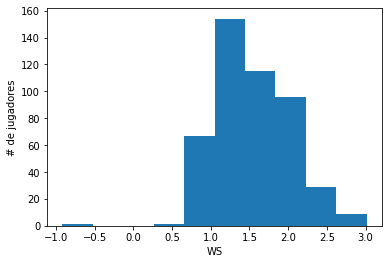

In [0]:
plt.hist(np.log(stats_now["WS"]+2.5))
plt.xlabel("WS")
plt.ylabel("# de jugadores")

Es mejor para regresion porque la distribucion esta mas concentrada y no tengo regiones subrepresentadas.

In [0]:
print(stats_now.iloc[np.where(stats_now["WS"]<0.0)])#el peor de todos

                  Player Pos Age   Tm   G  ...   WS/48  OBPM  DBPM   BPM  VORP
11          Lou Amundson  PF  33  NYK  29  ...  -0.014  -6.7  -0.2  -6.9  -0.3
16        James Anderson  SG  26  SAC  51  ...  -0.017  -3.9  -0.6  -4.5  -0.5
55          DeJuan Blair   C  26  WAS  29  ...  -0.015  -8.1  -0.7  -8.9  -0.4
69         Anthony Brown  SF  23  LAL  29  ...  -0.024  -4.5  -1.0  -5.5  -0.5
72          Kobe Bryant*  SF  37  LAL  66  ...  -0.010   0.9  -2.4  -1.6   0.2
101          Norris Cole  PG  27  NOP  45  ...  -0.004  -2.9  -0.9  -3.8  -0.5
105      Pat Connaughton  SG  23  POR  34  ...  -0.076  -4.8  -3.2  -8.0  -0.2
106       Chris Copeland  PF  31  MIL  24  ...  -0.017  -3.3  -3.1  -6.4  -0.2
167          Tim Frazier  PG  25  POR  35  ...  -0.051  -6.3  -0.4  -6.8  -0.3
247       Justin Holiday  SG  26  ATL  26  ...  -0.021  -6.1   0.4  -5.6  -0.2
257      Marcelo Huertas  PG  32  LAL  53  ...  -0.006  -2.7  -2.2  -5.0  -0.7
270        Damien Inglis  SF  20  MIL  20  ...  -0.0

Viendo WS tengo un par de opciones. En particular, aca voy a asignar clases dependiendo del cuartil de WS al que pertenece el jugador o a un sistema de binnes hecho de manera tal que el top 25 de jugadores este en su propia categoria. 


In [0]:
stats_now=stats_now[stats_now["WS"]>=-1.0]
#stats_now["X_q"]=pd.qcut(stats_now['WS/48'], 4)
#stats_now["X_q"]=pd.qcut(stats_now['WS'].values, 4).codes
stats_now["X_q"]=pd.cut(stats_now['WS'].values, bins=[-1.0,0.0,3.0,8.0,19]).codes
print(stats_now["X_q"].value_counts())
stats_now["X"]=np.log(stats_now["WS"]+2.5)

1    270
2    141
0     35
3     25
Name: X_q, dtype: int64


In [0]:
print(stats_now.iloc[np.where(stats_now["Player"]=="LeBron James")])

           Player Pos Age   Tm   G    MP  ... WS/48 OBPM DBPM  BPM VORP X_q
275  LeBron James  SF  31  CLE  76  2709  ...  .242  7.0  2.0  9.0  7.5   3

[1 rows x 27 columns]


Veamos si hay jugadores repetidos:

JaKarr Sampson      2
Lance Stephenson    2
Tobias Harris       2
Ty Lawson           2
Joe Johnson         2
                   ..
Brian Roberts       1
Brandon Rush        1
Patty Mills         1
Kyle Korver         1
Rajon Rondo         1
Name: Player, Length: 343, dtype: int64


(array([328.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  15.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <a list of 10 Patch objects>)

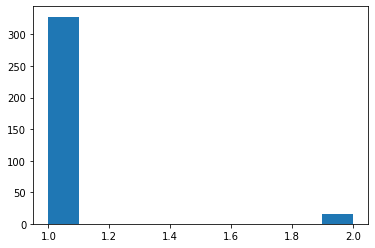

In [0]:
print(stats_now['Player'].value_counts())
plt.hist(stats_now['Player'].value_counts())

Los hay pero son pocos por lo que no me voy a gastar en corregirlo.

Convirtamos la posicion en un valor numerico.

In [0]:
stats_now=stats_now.replace(['PG','SG','SF','PF','C'],[1,2,3,4,5])
stats_now['Pos'].value_counts()

4    99
2    99
1    98
3    89
5    86
Name: Pos, dtype: int64

Revisemos que no hayan celdas vacias. Como es texto, utilizo el siguiente comando.

In [0]:
np.where(stats_now.applymap(lambda x: x == ''))

(array([], dtype=int64), array([], dtype=int64))

En particular, voy a estratificar (esto no se hace falta si hice cuartiles pero es necesario si utilice bines fijos)



In [0]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=445543)
for train_index, test_index in split.split(stats_now, stats_now["X_q"]):
    strat_train_set = stats_now.iloc[train_index]
    strat_test_set = stats_now.iloc[test_index]

Veamos si puedo implementar un ~clasificador~ regresor.

In [0]:
stats_train = strat_train_set.drop(["Player","Tm","X","X_q","OWS","DWS","WS","WS/48","OBPM","DBPM","BPM","VORP"], axis=1) # drop labels for training set
stats_train_labels = strat_train_set["X"].copy()
stats_test = strat_test_set.drop(["Player","Tm","X","X_q","OWS","DWS","WS","WS/48","OBPM","DBPM","BPM","VORP"], axis=1) # drop labels for training set
stats_test_labels = strat_test_set["X"].copy()


Veamos cuantos datos tengo para interpolar:

In [0]:
print(len(stats_train))

376


Armo una grilla para buscar los parametros que mejor interpolen utilizando cross-validation:

In [0]:
from sklearn.model_selection import GridSearchCV

clf = AdaBoostRegressor(base_estimator=DecisionTreeRegressor())

param_grid = {#"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best"],
              "base_estimator__max_depth": [3,4],
              "base_estimator__max_features": [5],
              "base_estimator__min_samples_leaf": [5],
              "learning_rate": [0.1,1.0],
              "n_estimators": [10,20,30]
             }

# run grid search
grid_search = GridSearchCV(clf, cv=10, param_grid=param_grid)
grid_search.fit(stats_train, stats_train_labels)

GridSearchCV(cv=10, error_score=nan,
             estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                                              criterion='mse',
                                                                              max_depth=None,
                                                                              max_features=None,
                                                                              max_leaf_nodes=None,
                                                                              min_impurity_decrease=0.0,
                                                                              min_impurity_split=None,
                                                                              min_samples_leaf=1,
                                                                              min_samples_split=2,
                                                                              mi

In [0]:
print(grid_search.best_estimator_)
print(grid_search.best_score_)
print(grid_search.cv_results_['mean_test_score'])
print(grid_search.cv_results_['std_test_score'])

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=4,
                                                       max_features=5,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=5,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
                  lea

Veamos cuanto overfitting hay comparando el mejor resultado con el resultado de fittear ese mejor modelo en todo el dataset de entrenamiento:

In [0]:
mejor_estimador=grid_search.best_estimator_
mejor_estimador.fit(stats_train, stats_train_labels)
print("Results is: ", mejor_estimador.score(stats_train, stats_train_labels))

Results is:  0.9323808700296812


Una ventaja de utilizar DT en cantidad es poder evaluar importancia de features.

In [0]:
features=np.asarray(list(stats_train.columns.values))
for i in range(len(features)):
  print((features[i],mejor_estimador.feature_importances_[i]))

('Pos', 0.0054784661838256)
('Age', 0.020475047173366352)
('G', 0.14246031607812457)
('MP', 0.2363089023726008)
('PER', 0.2093044108230553)
('TS%', 0.2602024139753787)
('3PAr', 0.0042042527470923866)
('FTr', 0.013928413698160372)
('ORB%', 0.01071639325632799)
('DRB%', 0.008863955738267306)
('TRB%', 0.022232297288982513)
('AST%', 0.006276238354052862)
('STL%', 0.012876654559349028)
('BLK%', 0.014864189811728351)
('TOV%', 0.022311939453910596)
('USG%', 0.009496108485777236)


De aqui podemos ver cuales son mas relevantes a la hora de estudiar "WS". Otra manera hubiese sido estudiar correlaciones, etc.

Veamos algun caso conocido para ver la prediccion

In [0]:
mejor_estimador.predict(stats_train.iloc[np.where(strat_train_set["Player"]=="James Harden")])

array([2.37742055])

Ahora dejo algunos codigos hechos para clasificaciones y para regresion

#Clasificacion

Podemos sacar mas informacion viendo la matriz de confusion

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(stats_train_labels,mejor_estimador.predict(stats_train))

array([[ 11,   0,   0,   0],
       [  0, 144,   0,   0],
       [  0,   0, 111,   0],
       [  0,   0,   0,  20]])

En efecto, algo que esta muy bien es que solo puedo mal interpretar de un cuartil a sus vecinos. Es decir, no voy a asignar a un jugador con muy bajo WS al cuartil con mas alto WS.

En particular, vamos a ver en que jugadores le pifio:

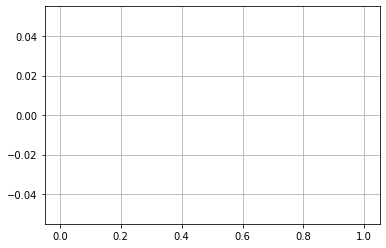

In [0]:
strat_train_set.iloc[np.where(mejor_estimador.predict(stats_train)!=stats_train_labels)]["X_q"].hist()

En particular, que jugadores "de elite" estoy pifiando?

In [0]:
strat_train_set.iloc[np.where(mejor_estimador.predict(stats_train)!=stats_train_labels)][["Player","X_q"]]

,Player,X_q


#Regresion

Si hice regresion, puedo ver cuan adecuada es mi interpolacion graficando prediccion vs realidad

Text(0, 0.5, 'Log(WS+2.5) predicted')

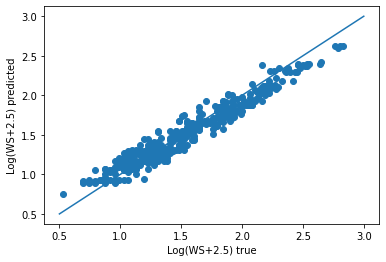

In [0]:
plt.scatter(stats_train_labels,mejor_estimador.predict(stats_train))
x=np.linspace(0.5,3,3)
plt.plot(x,x)
plt.xlabel("Log(WS+2.5) true")
plt.ylabel("Log(WS+2.5) predicted")

O directamente graficando ambas distribuciones

(array([26., 38., 78., 56., 51., 52., 32., 19., 20.,  4.]),
 array([0.75159762, 0.93906896, 1.1265403 , 1.31401164, 1.50148299,
        1.68895433, 1.87642567, 2.06389701, 2.25136835, 2.43883969,
        2.62631103]),
 <a list of 1 Patch objects>)

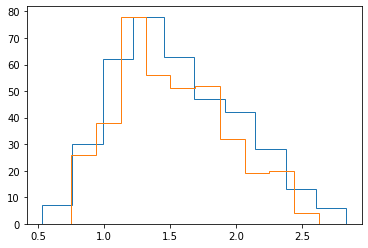

In [0]:
plt.hist(stats_train_labels,label='Train',histtype='step')
plt.hist(mejor_estimador.predict(stats_train),label='Prediccion',histtype='step')

Veamos el test. Nuevamente divido en clasficacion y en regresion

# Clasificacion

In [0]:
print(mejor_estimador.score(stats_test, stats_test_labels))
print(confusion_matrix(stats_test_labels,mejor_estimador.predict(stats_test)))

0.8055555555555556
[[ 0  3  0  0]
 [ 0 33  3  0]
 [ 0  4 24  0]
 [ 0  0  4  1]]


# Regresion

Text(0, 0.5, 'Log(WS+2.5) predicted')

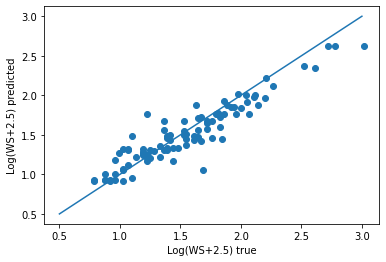

In [0]:
plt.scatter(stats_test_labels,mejor_estimador.predict(stats_test))
x=np.linspace(0.5,3,3)
plt.plot(x,x)
plt.xlabel("Log(WS+2.5) true")
plt.ylabel("Log(WS+2.5) predicted")